In [41]:
import pandas as pd
import numpy as np

from fbprophet import Prophet

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, Ridge, Lasso, Huber
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold, train_test_split

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
rides = pd.read_pickle('//home/michael/Documents/Projects/divvydataproject/data/pitchfulldataagg.pkl')
rides = rides[rides['datetime'].dt.year > 2013]
ride = rides.rename(columns={'outgoing':'net','net':'outgoing'}, inplace=True)


In [42]:
rides.shape

(34786, 23)

In [76]:
rides.head()

,datetime,stationid,temp,precip,incoming,net,outgoing,event_bears,event_blackhawks,event_bulls,...,event_sox,date,hour,maxout,maxin,name,lat,long,capacity,onlinedate
2507,2014-01-10 12:00:00,119,34.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2014-01-10,12,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
2508,2014-01-10 00:00:00,119,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2014-01-10,0,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
2509,2014-01-10 01:00:00,119,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2014-01-10,1,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
2510,2014-01-10 02:00:00,119,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2014-01-10,2,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
2511,2014-01-10 03:00:00,119,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2014-01-10,3,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00


In [77]:
pitchforkdates = pd.read_csv('/home/michael/Documents/Projects/divvydataproject/data/EventsManualList.csv')
pitchforkdates = pitchforkdates[pitchforkdates['Event'] == 'pitchfork']
dates = [x for x in pitchforkdates['Date']]
holiday = pd.DataFrame({
  'holiday': 'pitchfork',
  'ds': pd.to_datetime(dates)
})

/home/michael/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Train Error: 0.967036047260721
Val Error: 0.6949590610067685


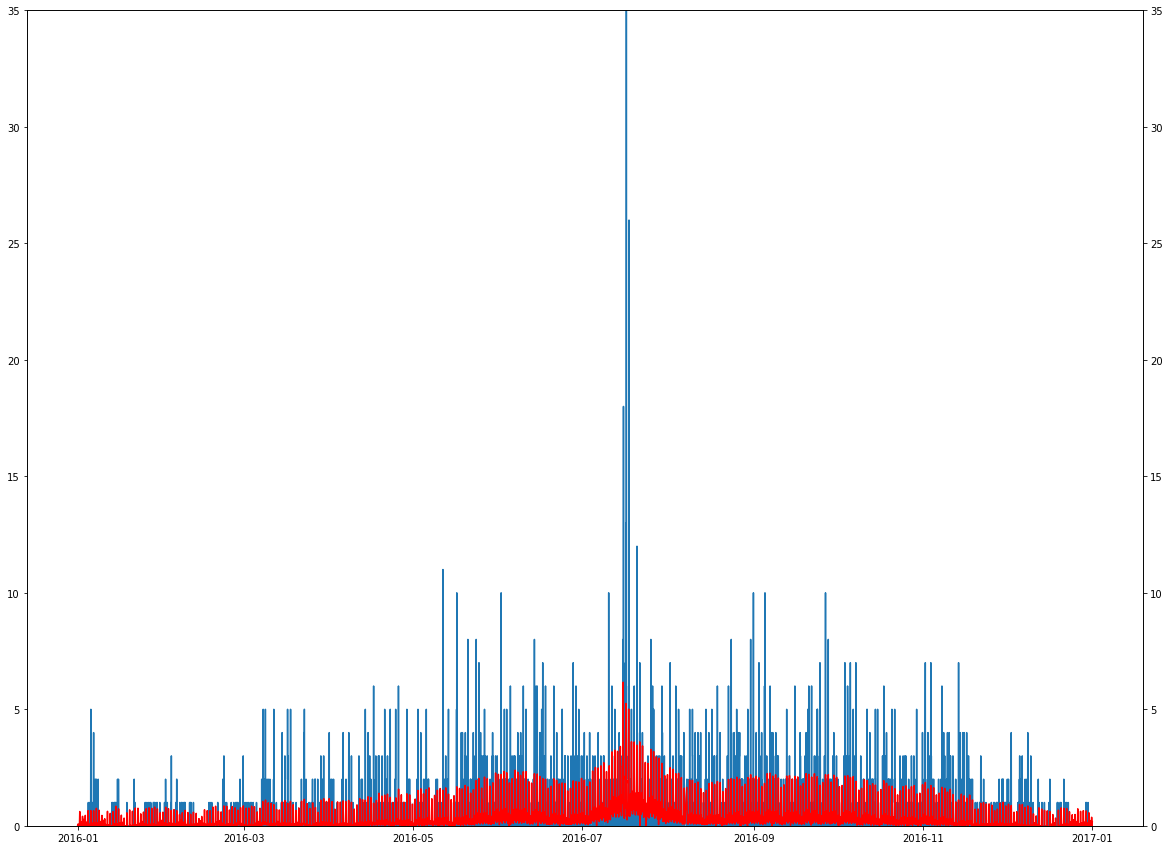

In [18]:
features = ['temp','precip','event_bears','event_blackhawks','event_bulls',
            'event_cubs','event_lollapalooza','event_pitchfork','event_sox','prophet']

testdata = rides[rides['stationid'] == 119].copy(deep = True)
train = testdata[testdata['datetime'].dt.year < 2017]

prophetdf = train[['datetime','outgoing']].copy(deep = True)
prophetdf.columns = ['ds','y']

m = Prophet()
m.fit(prophetdf)
future = m.make_future_dataframe(freq='H', periods=8760)
forecast = m.predict(future)

prophet = forecast[['ds','yhat']]
prophet.columns = ['datetime','prophet']
testdata = pd.merge(testdata, prophet, how = 'left', left_on = 'datetime', right_on = 'datetime')
testdata = testdata.fillna(0)

train = testdata[testdata['datetime'].dt.year < 2017]

val = testdata[(testdata['datetime'].dt.year >= 2017) & (testdata['datetime'].dt.month < 7)]

test = testdata[(testdata['datetime'].dt.year >= 2017)& (testdata['datetime'].dt.month >= 7)]

lin = LinearRegression(fit_intercept=True, n_jobs = -1)
model = make_pipeline(PolynomialFeatures(2), lin)
model.fit(train[features], train['outgoing'])

trainpredicto = model.predict(train[features])
valpredicto = model.predict(val[features])


print('Train Error: ' + str(np.sqrt(mean_squared_error(train['outgoing'], trainpredicto))))
print('Val Error: ' + str(np.sqrt(mean_squared_error(val['outgoing'], valpredicto))))


graph = True
if graph == True:
    plt.rcParams['agg.path.chunksize'] = 10000
    traingraph = train.copy(deep = True)
    traingraph['predict'] = trainpredicto
    traingraph = traingraph[traingraph['datetime'].dt.year > 2015]
    traingraph = traingraph.sort_values('datetime')

    fig, ax1 = plt.subplots(figsize = (20,15))
    ax1.plot(traingraph['datetime'] , traingraph['outgoing'])
    ax1.set_ylim([0,35])

    ax2 = ax1.twinx()
    ax2.plot(traingraph['datetime'], traingraph['predict'], color = 'r')
    ax2.set_ylim([0,35]);

/home/michael/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Train Error: 0.981538354199853
Val Error: 0.7319877875946025


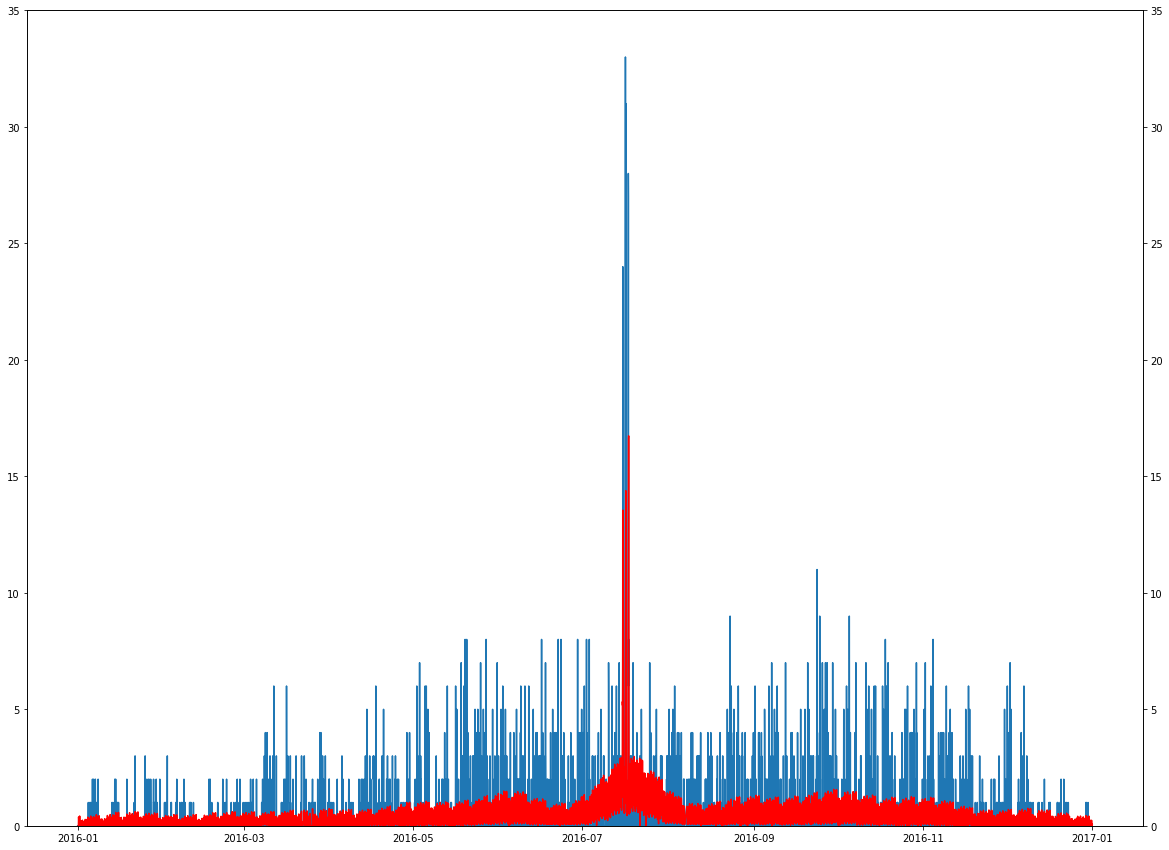

In [19]:
features = ['temp','precip','event_bears','event_blackhawks','event_bulls',
            'event_cubs','event_lollapalooza','event_pitchfork','event_sox','prophet']

testdata = rides[rides['stationid'] == 119].copy(deep = True)
train = testdata[testdata['datetime'].dt.year < 2017]

prophetdf = train[['datetime','incoming']].copy(deep = True)
prophetdf.columns = ['ds','y']

m = Prophet()
m.fit(prophetdf)
future = m.make_future_dataframe(freq='H', periods=8760)
forecast = m.predict(future)

prophet = forecast[['ds','yhat']]
prophet.columns = ['datetime','prophet']
testdata = pd.merge(testdata, prophet, how = 'left', left_on = 'datetime', right_on = 'datetime')
testdata = testdata.fillna(0)

train = testdata[testdata['datetime'].dt.year < 2017]

val = testdata[(testdata['datetime'].dt.year >= 2017) & (testdata['datetime'].dt.month < 7)]

test = testdata[(testdata['datetime'].dt.year >= 2017)& (testdata['datetime'].dt.month >= 7)]

lin = LinearRegression(fit_intercept=True, n_jobs = -1)
model = make_pipeline(PolynomialFeatures(2), lin)
model.fit(train[features], train['incoming'])

trainpredicti = model.predict(train[features])
valpredicti = model.predict(val[features])


print('Train Error: ' + str(np.sqrt(mean_squared_error(train['incoming'], trainpredicti))))
print('Val Error: ' + str(np.sqrt(mean_squared_error(val['incoming'], valpredicti))))


graph = True
if graph == True:
    plt.rcParams['agg.path.chunksize'] = 10000
    traingraph = train.copy(deep = True)
    traingraph['predict'] = trainpredicti
    traingraph = traingraph[traingraph['datetime'].dt.year > 2015]
    traingraph = traingraph.sort_values('datetime')

    fig, ax1 = plt.subplots(figsize = (20,15))
    ax1.plot(traingraph['datetime'] , traingraph['incoming'])
    ax1.set_ylim([0,35])

    ax2 = ax1.twinx()
    ax2.plot(traingraph['datetime'], traingraph['predict'], color = 'r')
    ax2.set_ylim([0,35]);

/home/michael/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Train Error: 1.0589278767055281
Val Error: 0.5351188833479272


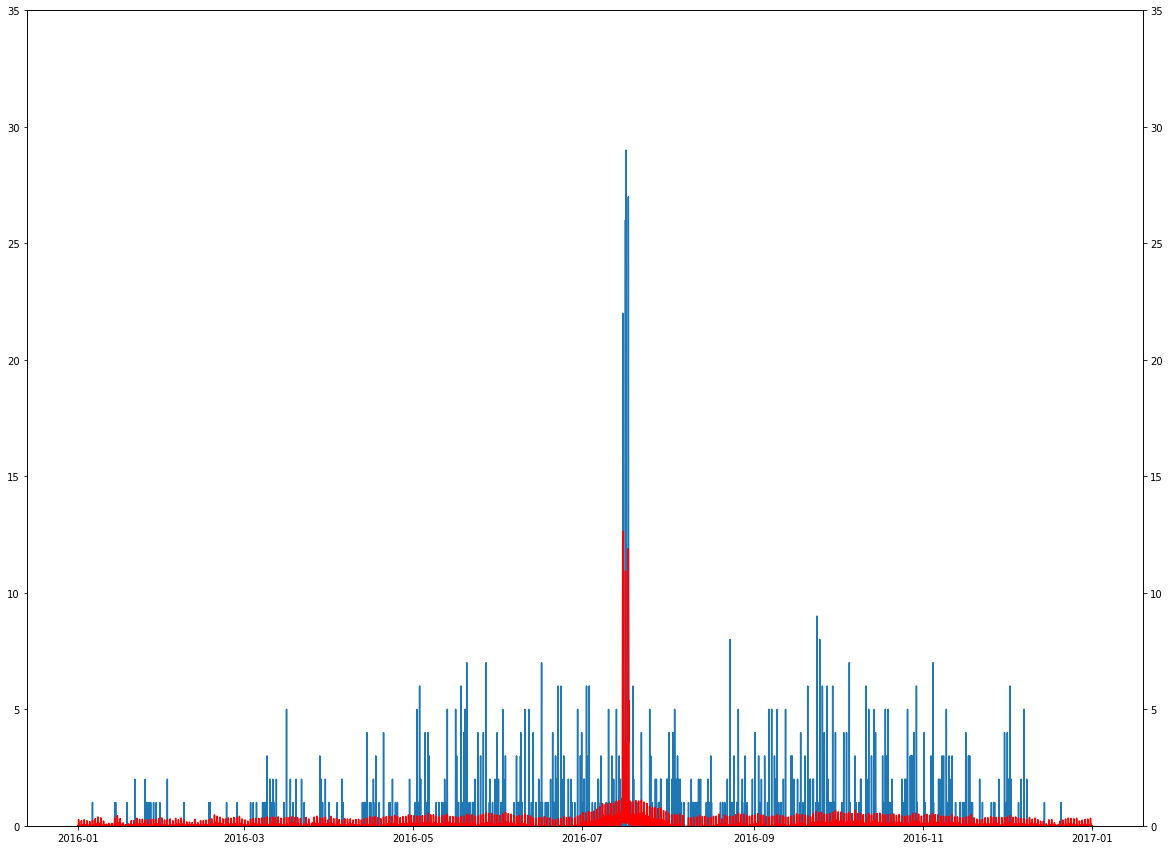

In [20]:
features = ['temp','precip','event_bears','event_blackhawks','event_bulls',
            'event_cubs','event_lollapalooza','event_pitchfork','event_sox','prophet']

testdata = rides[rides['stationid'] == 119].copy(deep = True)
train = testdata[testdata['datetime'].dt.year < 2017]

prophetdf = train[['datetime','net']].copy(deep = True)
prophetdf.columns = ['ds','y']

m = Prophet()
m.fit(prophetdf)
future = m.make_future_dataframe(freq='H', periods=8760)
forecast = m.predict(future)

prophet = forecast[['ds','yhat']]
prophet.columns = ['datetime','prophet']
testdata = pd.merge(testdata, prophet, how = 'left', left_on = 'datetime', right_on = 'datetime')
testdata = testdata.fillna(0)

train = testdata[testdata['datetime'].dt.year < 2017]

val = testdata[(testdata['datetime'].dt.year >= 2017) & (testdata['datetime'].dt.month < 7)]

test = testdata[(testdata['datetime'].dt.year >= 2017)& (testdata['datetime'].dt.month >= 7)]

lin = LinearRegression(fit_intercept=True, n_jobs = -1)
model = make_pipeline(PolynomialFeatures(2), lin)
model.fit(train[features], train['net'])

trainpredictn = model.predict(train[features])
valpredictn = model.predict(val[features])


print('Train Error: ' + str(np.sqrt(mean_squared_error(train['net'], trainpredictn))))
print('Val Error: ' + str(np.sqrt(mean_squared_error(val['net'], valpredictn))))


graph = True
if graph == True:
    plt.rcParams['agg.path.chunksize'] = 10000
    traingraph = train.copy(deep = True)
    traingraph['predict'] = trainpredictn
    traingraph = traingraph[traingraph['datetime'].dt.year > 2015]
    traingraph = traingraph.sort_values('datetime')

    fig, ax1 = plt.subplots(figsize = (20,15))
    ax1.plot(traingraph['datetime'] , traingraph['net'])
    ax1.set_ylim([0,35])

    ax2 = ax1.twinx()
    ax2.plot(traingraph['datetime'], traingraph['predict'], color = 'r')
    ax2.set_ylim([0,35]);

/home/michael/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Train Error: 1.0582451735639689
Val Error: 0.5316465608419229
Prophet Val Error: 0.539224005569427


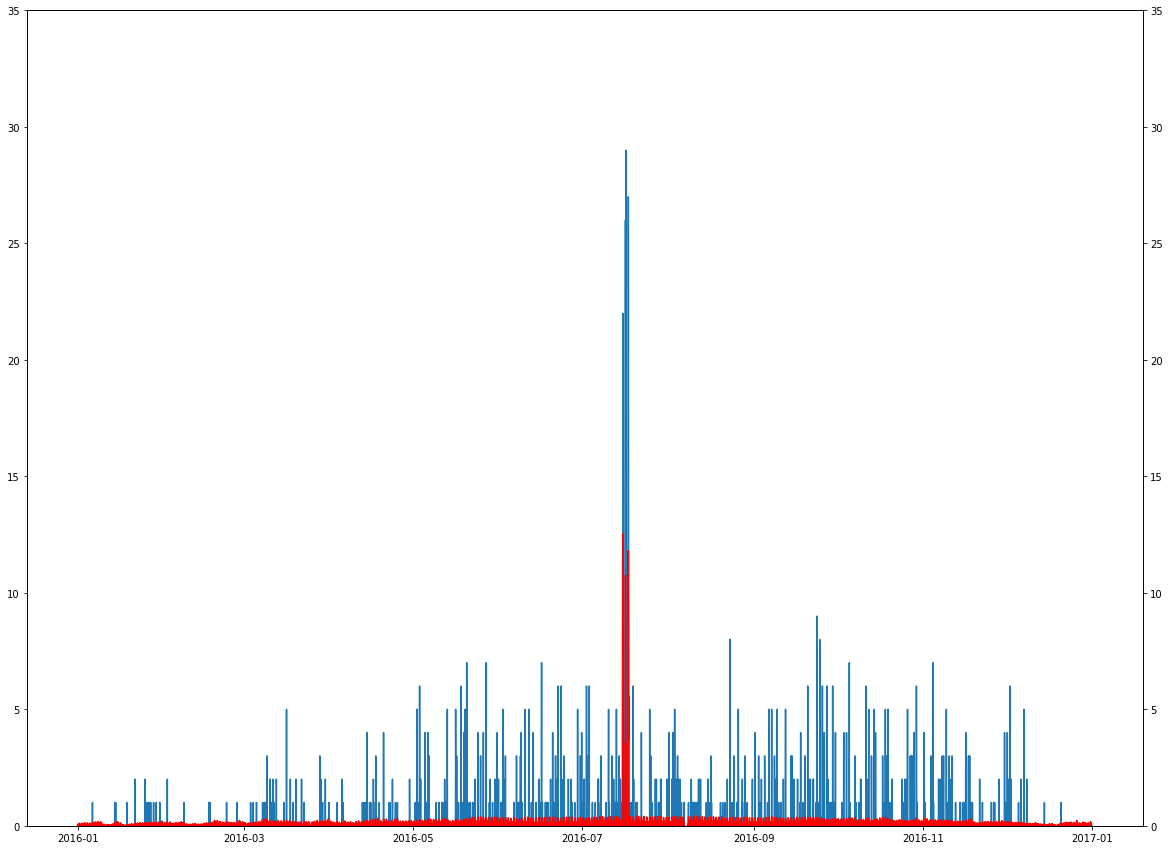

In [82]:
features = ['temp','precip','event_bears','event_blackhawks','event_bulls',
            'event_cubs','event_lollapalooza','event_pitchfork','event_sox','prophet']

testdata = rides[rides['stationid'] == 119].copy(deep = True)
train = testdata[testdata['datetime'].dt.year < 2017]

prophetdf = train[['datetime','net']].copy(deep = True)
prophetdf.columns = ['ds','y']

m = Prophet(holidays = holiday)
m.fit(prophetdf)
future = m.make_future_dataframe(freq='H', periods=8760)
forecast = m.predict(future)

prophet = forecast[['ds','yhat']]
prophet.columns = ['datetime','prophet']
testdata = pd.merge(testdata, prophet, how = 'left', left_on = 'datetime', right_on = 'datetime')
testdata = testdata.fillna(0)

train = testdata[testdata['datetime'].dt.year < 2017]

val = testdata[(testdata['datetime'].dt.year >= 2017) & (testdata['datetime'].dt.month < 7)]

test = testdata[(testdata['datetime'].dt.year >= 2017)& (testdata['datetime'].dt.month >= 7)]

lin = LinearRegression(fit_intercept=True, n_jobs = -1)
model = make_pipeline(PolynomialFeatures(2), lin)
model.fit(train[features], train['net'])

trainpredictn = model.predict(train[features])
valpredictn = model.predict(val[features])


print('Train Error: ' + str(np.sqrt(mean_squared_error(train['net'], trainpredictn))))
print('Val Error: ' + str(np.sqrt(mean_squared_error(val['net'], valpredictn))))
print('Prophet Val Error: ' + str(np.sqrt(mean_squared_error(val['net'], val['prophet']))))

graph = True
if graph == True:
    plt.rcParams['agg.path.chunksize'] = 10000
    traingraph = train.copy(deep = True)
    traingraph['predict'] = trainpredictn
    traingraph = traingraph[traingraph['datetime'].dt.year > 2015]
    traingraph = traingraph.sort_values('datetime')

    fig, ax1 = plt.subplots(figsize = (20,15))
    ax1.plot(traingraph['datetime'] , traingraph['net'])
    ax1.set_ylim([0,35])

    ax2 = ax1.twinx()
    ax2.plot(traingraph['datetime'], traingraph['predict'], color = 'r')
    ax2.set_ylim([0,35]);

In [83]:
rides['net'].mean()

0.025929971827746794

In [25]:
newdf = train[['datetime','incoming','outgoing','net']].copy(deep = True)
newdf['predinc'] = trainpredicti
newdf['predinc'] = np.where(newdf['predinc'] < 0, 0 ,newdf['predinc'])
newdf['predout'] = trainpredicto
newdf['predout'] = np.where(newdf['predout'] < 0, 0 ,newdf['predout'])
newdf['prednet'] = trainpredictn
newdf['calcnet'] = newdf['predinc'] - newdf['predout'] 

In [29]:
newdf.sort_values('prednet', ascending = False).head(10)

,datetime,incoming,outgoing,net,predinc,predout,prednet,calcnet
8975,2015-07-18 15:00:00,21.0,1.0,20.0,22.836218,0.000000,23.504413,22.836218
8953,2015-07-17 14:00:00,10.0,1.0,9.0,13.000427,1.528624,13.978326,11.471803
8954,2015-07-17 15:00:00,13.0,2.0,11.0,15.784538,2.249596,13.689633,13.534942
16466,2016-07-15 15:00:00,24.0,2.0,22.0,11.946328,2.914578,12.641864,9.031749
8994,2015-07-18 14:00:00,0.0,0.0,0.0,9.693667,1.528528,12.560733,8.165139
8998,2015-07-19 14:00:00,39.0,1.0,38.0,9.526404,1.602717,12.423472,7.923687
8999,2015-07-19 15:00:00,27.0,4.0,23.0,12.078919,2.331059,11.986076,9.747860
16514,2016-07-17 15:00:00,28.0,1.0,27.0,12.183381,2.483091,11.900217,9.700290
16513,2016-07-17 14:00:00,11.0,1.0,10.0,8.774295,1.903938,11.889901,6.870357
2879,2014-07-18 14:00:00,5.0,1.0,4.0,7.126047,1.800170,11.862786,5.325877


In [30]:
newdf.sort_values('calcnet', ascending = False).tail(20)

,datetime,incoming,outgoing,net,predinc,predout,prednet,calcnet
8042,2015-06-09 18:00:00,2.0,8.0,-6.0,1.176663,2.192990,-0.305959,-1.016327
17870,2016-09-12 18:00:00,3.0,5.0,-2.0,1.118122,2.134537,-0.226073,-1.016415
15548,2016-06-06 18:00:00,0.0,0.0,0.0,1.364170,2.385586,-0.237128,-1.021416
15629,2016-06-10 18:00:00,1.0,5.0,-4.0,1.303722,2.326343,-0.337878,-1.022622
16925,2016-08-03 18:00:00,1.0,6.0,-5.0,1.212803,2.238311,-0.310674,-1.025507
8368,2015-06-22 18:00:00,0.0,0.0,0.0,0.736545,1.762301,-0.308910,-1.025756
17050,2016-08-09 18:00:00,2.0,5.0,-3.0,0.925528,1.953085,-0.328492,-1.027556
17028,2016-08-08 18:00:00,2.0,5.0,-3.0,0.924614,1.963540,-0.287107,-1.038926
18035,2016-09-19 18:00:00,1.0,4.0,-3.0,1.195739,2.239341,-0.292901,-1.043602
16901,2016-08-02 18:00:00,1.0,3.0,-2.0,1.380952,2.426039,-0.282095,-1.045087


In [34]:
features = ['temp','precip','event_bears','event_blackhawks','event_bulls',
            'event_cubs','event_lollapalooza','event_pitchfork','event_sox','prophet']

testdata = rides[rides['stationid'] == 119].copy(deep = True)
train = testdata[testdata['datetime'].dt.year < 2017]

prophetdf = train[['datetime','net']].copy(deep = True)
prophetdf.columns = ['ds','y']

m = Prophet()
m.fit(prophetdf)
future = m.make_future_dataframe(freq='H', periods=8760)
forecast = m.predict(future)

prophet = forecast[['ds','yhat']]
prophet.columns = ['datetime','prophet']
testdata = pd.merge(testdata, prophet, how = 'left', left_on = 'datetime', right_on = 'datetime')
testdata = testdata.fillna(0)

train = testdata[testdata['datetime'].dt.year < 2017]

test = testdata[(testdata['datetime'].dt.year == 2017)]

lin = LinearRegression(fit_intercept=True, n_jobs = -1)
model = make_pipeline(PolynomialFeatures(2), lin)
model.fit(train[features], train['net'])

trainpredict2017 = model.predict(train[features])
testpredict2017 = model.predict(test[features])


print('Train Error: ' + str(np.sqrt(mean_squared_error(train['net'], trainpredict2017))))
print('Val Error: ' + str(np.sqrt(mean_squared_error(test['net'], testpredict2017))))

/home/michael/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Train Error: 1.0589278767055281
Val Error: 0.8174713868845562


In [39]:
data2017 = test.copy(deep = True)
data2017['prednet'] = testpredict2017
data2017 = data2017[['datetime','stationid','prednet']]
data2017.to_pickle('/home/michael/Documents/Projects/divvydataproject/data/2017predict.pkl')

In [71]:
pred2018data = rides[rides['stationid'] == 119].copy(deep = True)
pred2018data = pred2018data[pred2018data['datetime'].dt.year == 2017]
pred2018data['datetime'] = pred2018data['datetime'] + pd.DateOffset(years = 1)
pred2018data['event_pitchfork'] = 0
phours2018 = [12,13,14,15,16,17,18,19,20]
pred2018data['event_pitchfork'] = np.where(((pred2018data['datetime'].dt.month == 7) & (pred2018data['datetime'].dt.day == 20)& (pred2018data['hour'].isin(phours2018))) |
                                           ((pred2018data['datetime'].dt.month == 7) & (pred2018data['datetime'].dt.day == 21)& (pred2018data['hour'].isin(phours2018))) | 
                                           ((pred2018data['datetime'].dt.month == 7) & (pred2018data['datetime'].dt.day == 22)& (pred2018data['hour'].isin(phours2018))),1, 0)

In [72]:
pred2018data.head()

,datetime,stationid,temp,precip,incoming,net,outgoing,event_bears,event_blackhawks,event_bulls,...,event_sox,date,hour,maxout,maxin,name,lat,long,capacity,onlinedate
22722,2018-01-03 10:00:00,119,39.0,0.0,1.0,-1.0,2.0,0.0,0.0,0.0,...,0.0,2017-01-03,10,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
22723,2018-01-03 16:00:00,119,37.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2017-01-03,16,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
22724,2018-01-03 18:00:00,119,35.0,0.0,1.0,-2.0,3.0,0.0,0.0,0.0,...,0.0,2017-01-03,18,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
22725,2018-01-03 19:00:00,119,34.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2017-01-03,19,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00
22726,2018-01-03 00:00:00,119,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2017-01-03,0,0.0,1.0,Ashland Ave & Lake St,41.88541,-87.66732,19,2013-07-18 17:21:00


In [73]:
features = ['temp','precip','event_bears','event_blackhawks','event_bulls',
            'event_cubs','event_lollapalooza','event_pitchfork','event_sox','prophet']

traindata = rides[rides['stationid'] == 119].copy(deep = True)
traindata = traindata[traindata['datetime'].dt.year < 2018]

prophetdf = traindata[['datetime','net']].copy(deep = True)
prophetdf.columns = ['ds','y']

m = Prophet()
m.fit(prophetdf)
future = m.make_future_dataframe(freq='H', periods=8760)
forecast = m.predict(future)

prophet = forecast[['ds','yhat']]
prophet.columns = ['datetime','prophet']

prophetold = prophet[prophet['datetime'].dt.year <  2018]
prophetnew = prophet[prophet['datetime'].dt.year ==  2018]

traindata = pd.merge(traindata, prophetold, how = 'left', left_on = 'datetime', right_on = 'datetime')
traindata = traindata.fillna(0)

testdata = pd.merge(pred2018data, prophetnew, how = 'left', left_on = 'datetime', right_on = 'datetime')
testdata = testdata.fillna(0)

lin = LinearRegression(fit_intercept=True, n_jobs = -1)
model = make_pipeline(PolynomialFeatures(2), lin)
model.fit(traindata[features], traindata['net'])



trainpredict2018 = model.predict(traindata[features])
testpredict2018 = model.predict(testdata[features])


print('Train Error: ' + str(np.sqrt(mean_squared_error(traindata['net'], trainpredict2018))))

/home/michael/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Train Error: 0.9977719081976141


In [74]:
data2018 = testdata.copy(deep = True)
data2018['prednet'] = testpredict2018
data2018 = data2018[['datetime','stationid','prednet']]
data2018.to_pickle('/home/michael/Documents/Projects/divvydataproject/data/2018predict.pkl')

In [75]:
data2018.head()

,datetime,stationid,prednet
0,2018-01-03 10:00:00,119,0.017047
1,2018-01-03 16:00:00,119,0.005249
2,2018-01-03 18:00:00,119,-0.050861
3,2018-01-03 19:00:00,119,-0.048604
4,2018-01-03 00:00:00,119,-0.031908
